In [1]:
from round import lc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
light_curve = lc.LightCurve.everest("https://archive.stsci.edu/hlsps/everest/v2/c102/201000000/48855/hlsp_everest_k2_llc_201048855-c102_kepler_v2.0_lc.fits");
%time light_curve.compute()

optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod_interval__', 'logamp', 'logs2', 'mean']
message: Desired error not necessarily achieved due to precision loss.
logp: 17512.98589072632 -> 17827.309941146552


Sampling 2 chains: 100%|██████████| 404/404 [00:10<00:00, 38.61draws/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]
Sampling 2 chains: 100%|██████████| 1000/1000 [00:27<00:00, 36.68draws/s]
The acceptance probability does not match the target. It is 0.9671218498711803, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9603467414428344, but should be close to 0.9. Try to increase the number of tuning steps.


CPU times: user 1min 1s, sys: 2 s, total: 1min 3s
Wall time: 3min 1s


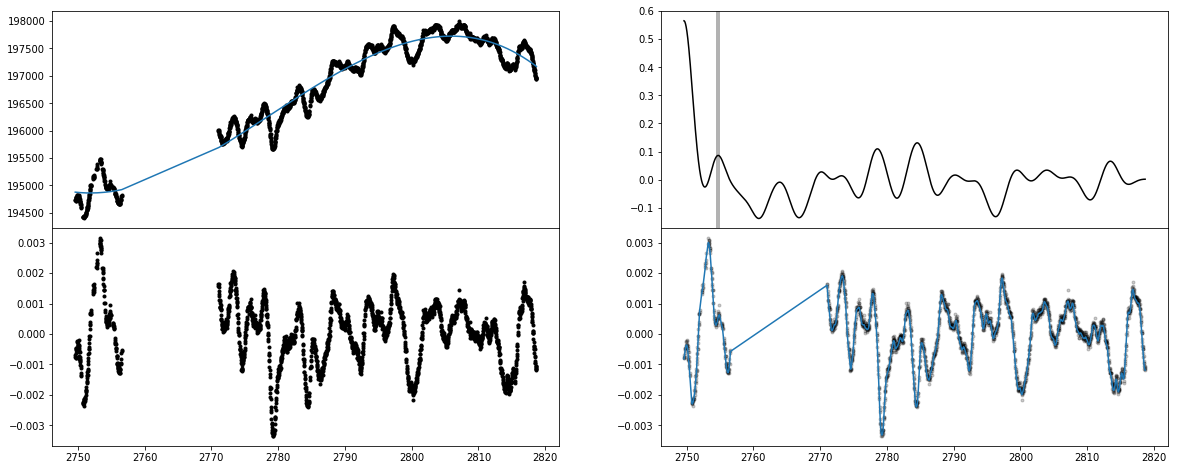

<Figure size 432x288 with 0 Axes>

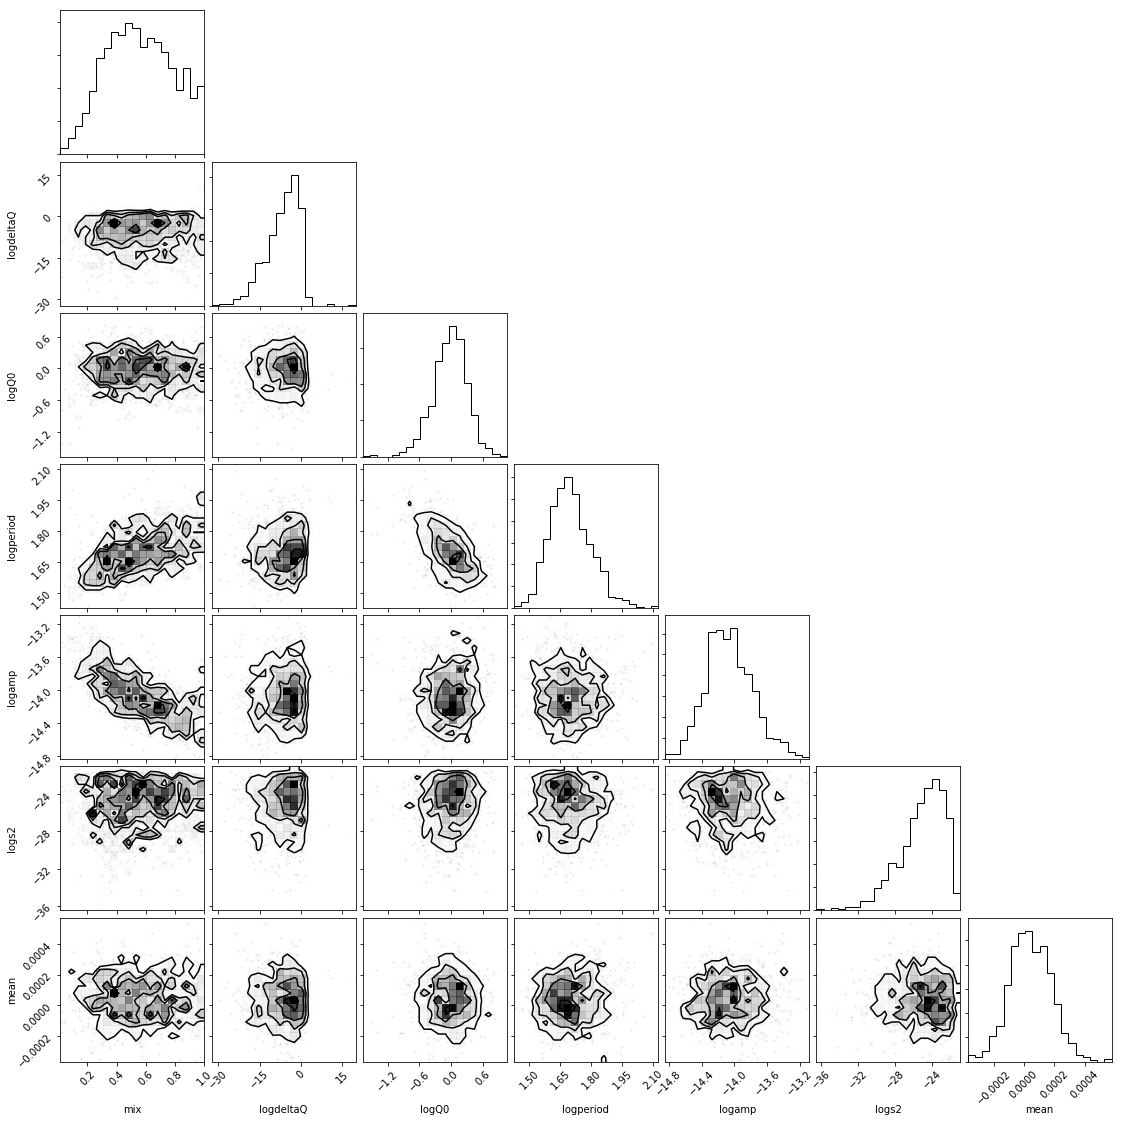

In [3]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20, 8))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], wspace=0.1, hspace=0)
ax = plt.Subplot(fig, inner[0])
light_curve.plot_raw(ax)
fig.add_subplot(ax)
ax = plt.Subplot(fig, inner[1])
light_curve.plot(ax)
fig.add_subplot(ax)

inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1], wspace=0.1, hspace=0)
ax = plt.Subplot(fig, inner[0])
light_curve.plot_autocor(ax)
fig.add_subplot(ax)
ax = plt.Subplot(fig, inner[1])
light_curve.plot_map_soln(ax)
fig.add_subplot(ax)

light_curve.plot_corner();

In [ ]:
subfig1, axs = plt.subplots(2, 1)
subfig1.add_subplot(f1.gca())

In [ ]:
light_curve.mcmc_summary